In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv3D, Flatten,MaxPooling3D,AveragePooling3D, concatenate,Input

from math import e
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from joblib import dump, load

In [2]:
fogData = xr.open_dataset('../../../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
yAll=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2018-12-31'))
yAll=yAll/25.0
#y

In [3]:
# Input Data
t2mData = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
d2mData = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_d2m_daily_NovDecJan.nc')
u10Data = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_u10_daily_NovDecJan.nc')
v10Data = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_v10_daily_NovDecJan.nc')
z500Data = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_500_z_daily_NovDecJan.nc')
uvt850Data = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_uvt_daily_NovDecJan.nc')

In [4]:
rh = (e**((17.625*(d2mData.d2m.values-273.15))/(243.04+(d2mData.d2m.values-273.15)))/e**((17.625*(t2mData.t2m.values-273.15))/(243.04+(t2mData.t2m.values-273.15))))

rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [5]:
t2m=t2mData.t2m.shift(time=1)
rh=rh_ds.rh.shift(time=1)
u10=u10Data.u10.shift(time=1)
v10=v10Data.v10.shift(time=1)
z=z500Data.z.shift(time=1)
t850=uvt850Data.t.shift(time=1)
u850=uvt850Data.u.shift(time=1)
v850=uvt850Data.v.shift(time=1)

In [6]:
t2mTsAll=t2m[((t2m.time.dt.month>11) | (t2m.time.dt.month<2)) & (t2m.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
rhTsAll=rh[((rh.time.dt.month>11) | (rh.time.dt.month<2)) & (rh.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
u10TsAll=u10[((u10.time.dt.month>11) | (u10.time.dt.month<2)) & (u10.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
v10TsAll=u10[((v10.time.dt.month>11) | (v10.time.dt.month<2)) & (v10.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
zTsAll=z[((z.time.dt.month>11) | (z.time.dt.month<2)) & (z.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
t850TsAll=t850[((t850.time.dt.month>11) | (t850.time.dt.month<2)) & (t850.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
u850TsAll=u850[((u850.time.dt.month>11) | (u850.time.dt.month<2)) & (u850.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
v850TsAll=v850[((v850.time.dt.month>11) | (v850.time.dt.month<2)) & (v850.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))

In [7]:
t1=t2mTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
t2mTsAll.values=t1.unstack()

t1=rhTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
rhTsAll.values=t1.unstack()

t1=u10TsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
u10TsAll.values=t1.unstack()

t1=v10TsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
v10TsAll.values=t1.unstack()

t1=zTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
zTsAll.values=t1.unstack()


t1=t850TsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
t850TsAll.values=t1.unstack()

t1=u850TsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
u850TsAll.values=t1.unstack()

t1=v850TsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
v850TsAll.values=t1.unstack()

In [8]:
zTs=zTsAll.sel(time=slice('1984-1-1','2014-12-31'))
               
t2mTs=t2mTsAll.sel(time=slice('1984-1-1','2014-12-31'))
t850Ts=t850TsAll.sel(time=slice('1984-1-1','2014-12-31'))
u850Ts=u850TsAll.sel(time=slice('1984-1-1','2014-12-31'))
v850Ts=v850TsAll.sel(time=slice('1984-1-1','2014-12-31'))
rhTs=rhTsAll.sel(time=slice('1984-1-1','2014-12-31'))
v10Ts=v10TsAll.sel(time=slice('1984-1-1','2014-12-31'))
u10Ts=u10TsAll.sel(time=slice('1984-1-1','2014-12-31'))
y=yAll.sel(time=slice('1984-1-1','2014-12-31'))

In [9]:
z_train, z_test,t2m_train, t2m_test,t850_train, t850_test,u850_train, u850_test,v850_train, v850_test,   rh_train, rh_test,v10_train, v10_test,u10_train, u10_test,y_train,y_test = train_test_split( zTs,t2mTs,t850Ts,u850Ts,v850Ts, rhTs,v10Ts,u10Ts,y,test_size=0.20, random_state=0)

In [10]:
z_trainf, z_val,t2m_trainf, t2m_val,t850_trainf, t850_val,u850_trainf, u850_val,v850_trainf, v850_val, rh_trainf, rh_val,v10_trainf, v10_val,u10_trainf, u10_val,y_trainf,y_val = train_test_split( z_train,t2m_train,t850_train,u850_train,v850_train, rh_train,v10_train,u10_train,y_train,test_size=0.20, random_state=0)

In [11]:
t2mtrainf=t2m_trainf.values
t2mtrainf=t2mtrainf[:,:,:,None]
t2mtrainf.shape

t850trainf=t850_trainf.values
t850trainf=t850trainf[:,:,:,None]
t850trainf.shape


u850trainf=u850_trainf.values
u850trainf=u850trainf[:,:,:,None]
u850trainf.shape


v850trainf=v850_trainf.values
v850trainf=v850trainf[:,:,:,None]
v850trainf.shape

rhtrainf=rh_trainf.values
rhtrainf=rhtrainf[:,:,:,None]
rhtrainf.shape

ztrainf=z_trainf.values
ztrainf=ztrainf[:,:,:,None]
ztrainf.shape

u10trainf=u10_trainf.values
u10trainf=u10trainf[:,:,:,None]
u10trainf.shape

v10trainf=v10_trainf.values
v10trainf=v10trainf[:,:,:,None]
v10trainf.shape

(1229, 18, 26, 1)

In [12]:
ytrainf=y_trainf.values
ytrainf=ytrainf[:,None]
ytrainf.shape

(1229, 1)

In [13]:
t2mtest=t2m_test.values
t2mtest=t2mtest[:,:,:,None]
t2mtest.shape

t850test=t850_test.values
t850test=t850test[:,:,:,None]
t850test.shape

u850test=u850_test.values
u850test=u850test[:,:,:,None]
u850test.shape


v850test=v850_test.values
v850test=v850test[:,:,:,None]
v850test.shape


rhtest=rh_test.values
rhtest=rhtest[:,:,:,None]
rhtest.shape
u10test=u10_test.values
u10test=u10test[:,:,:,None]
u10test.shape
ztest=z_test.values
ztest=ztest[:,:,:,None]
ztest.shape

v10test=v10_test.values
v10test=v10test[:,:,:,None]
v10test.shape

(385, 18, 26, 1)

In [14]:
t2mval=t2m_val.values
t2mval=t2mval[:,:,:,None]
t2mval.shape
rhval=rh_val.values
rhval=rhval[:,:,:,None]
rhval.shape
u10val=u10_val.values
u10val=u10val[:,:,:,None]
u10val.shape
zval=z_val.values
zval=zval[:,:,:,None]
zval.shape

v10val=v10_val.values
v10val=v10val[:,:,:,None]
v10val.shape

t850val=t850_val.values
t850val=t850val[:,:,:,None]
t850val.shape

u850val=u850_val.values
u850val=u850val[:,:,:,None]
u850val.shape

v850val=v850_val.values
v850val=v850val[:,:,:,None]
v850val.shape

(308, 18, 26, 1)

In [15]:
ytest=y_test.values
ytest=ytest[:,None]
ytest.shape

(385, 1)

In [16]:
yval=y_val.values
yval=yval[:,None]
yval.shape

(308, 1)

In [17]:
X_test=np.array([ztest,rhtest,u10test,v10test,t2mtest])
X_test.shape

X_trainf=np.array([ztrainf,rhtrainf,u10trainf,v10trainf,t2mtrainf])
X_trainf.shape

X_val=np.array([zval,rhval,u10val,v10val,t2mval])
X_val.shape

(5, 308, 18, 26, 1)

In [18]:
X_trainf_reshape = np.einsum('lkija->klija',X_trainf)
X_trainf_reshape.shape

X_test_reshape = np.einsum('lkija->klija',X_test)
X_test_reshape.shape

X_val_reshape = np.einsum('lkija->klija',X_val)
X_val_reshape.shape

(308, 5, 18, 26, 1)

Epoch 1/10
39/39 [==============================] - 13s 330ms/step - loss: 1.5003 - val_loss: 0.1777
Epoch 2/10
39/39 [==============================] - 13s 321ms/step - loss: 0.1734 - val_loss: 0.1600
Epoch 3/10
39/39 [==============================] - 12s 319ms/step - loss: 0.1710 - val_loss: 0.1320
Epoch 4/10
39/39 [==============================] - 12s 321ms/step - loss: 0.1373 - val_loss: 0.1215
Epoch 5/10
39/39 [==============================] - 12s 317ms/step - loss: 0.1229 - val_loss: 0.1063
Epoch 6/10
39/39 [==============================] - 13s 324ms/step - loss: 0.1078 - val_loss: 0.0982
Epoch 7/10
39/39 [==============================] - 12s 317ms/step - loss: 0.1012 - val_loss: 0.0981
Epoch 8/10
39/39 [==============================] - 12s 315ms/step - loss: 0.0902 - val_loss: 0.0949
Epoch 9/10
39/39 [==============================] - 12s 318ms/step - loss: 0.0952 - val_loss: 0.0938
Epoch 10/10
39/39 [==============================] - 13s 322ms/step - loss: 0.0858 - val_lo

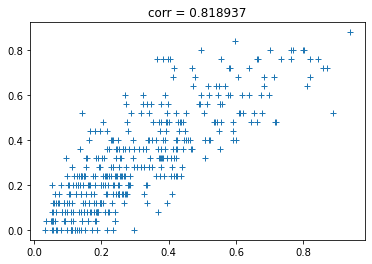

In [20]:
model = Sequential()

model.add(Conv3D(filters=32, kernel_size=5, activation='relu',padding='same', input_shape=(X_trainf_reshape.shape[1],X_trainf_reshape.shape[2],X_trainf_reshape.shape[3],1)))
model.add(MaxPooling3D())

model.add(Conv3D(filters=64, kernel_size=3, activation='relu',padding='same'))
#model.add(MaxPooling3D())
model.add(Conv3D(filters=128, kernel_size=3, activation='relu',padding='same'))

model.add(Conv3D(filters=256, kernel_size=3, activation='relu',padding='same'))

#model.add(Conv3D(filters=512, kernel_size=3, activation='relu',padding='same'))

#model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
#model.add(Conv2D(filters=3, kernel_size=(1, 1), activation='relu'))
#model.add(AveragePooling2D())

model.add(Flatten())

#model.add(Dense(units=120, activation='relu'))

model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation = 'linear'))

model.compile(optimizer='adam', loss='mae')

history = model.fit(X_trainf_reshape, ytrainf, validation_data=(X_val_reshape, yval), epochs=10)
yy_test = model.predict(X_test_reshape)

test_corr = np.corrcoef(yy_test[:,0],y_test)[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,ytest,'+')

# Run model on all data together 

In [21]:
z_train, z_test,t2m_train, t2m_test,t850_train, t850_test,u850_train, u850_test,v850_train, v850_test,   rh_train, rh_test,v10_train, v10_test,u10_train, u10_test,y_train,y_test = train_test_split( zTs,t2mTs,t850Ts,u850Ts,v850Ts, rhTs,v10Ts,u10Ts,y,test_size=0.20, random_state=0)

In [23]:
t2mtrain=t2m_train.values
t2mtrain=t2mtrain[:,:,:,None]
t2mtrain.shape

t850train=t850_train.values
t850train=t850train[:,:,:,None]
t850train.shape


u850train=u850_train.values
u850train=u850train[:,:,:,None]
u850train.shape


v850train=v850_train.values
v850train=v850train[:,:,:,None]
v850train.shape

rhtrain=rh_train.values
rhtrain=rhtrain[:,:,:,None]
rhtrain.shape

ztrain=z_train.values
ztrain=ztrain[:,:,:,None]
ztrain.shape

u10train=u10_train.values
u10train=u10train[:,:,:,None]
u10train.shape

v10train=v10_train.values
v10train=v10train[:,:,:,None]
v10train.shape

(1537, 18, 26, 1)

In [24]:
t2mtest=t2m_test.values
t2mtest=t2mtest[:,:,:,None]
t2mtest.shape

t850test=t850_test.values
t850test=t850test[:,:,:,None]
t850test.shape

u850test=u850_test.values
u850test=u850test[:,:,:,None]
u850test.shape


v850test=v850_test.values
v850test=v850test[:,:,:,None]
v850test.shape


rhtest=rh_test.values
rhtest=rhtest[:,:,:,None]
rhtest.shape
u10test=u10_test.values
u10test=u10test[:,:,:,None]
u10test.shape
ztest=z_test.values
ztest=ztest[:,:,:,None]
ztest.shape

v10test=v10_test.values
v10test=v10test[:,:,:,None]
v10test.shape

(385, 18, 26, 1)

In [25]:
ytrain=y_train.values
ytrain=ytrain[:,None]
ytrain.shape
ytest=y_test.values
ytest=ytest[:,None]
ytest.shape

(385, 1)

In [26]:
X_test=np.array([ztest,rhtest,u10test,v10test,t2mtest])
X_test.shape

X_train=np.array([ztrain,rhtrain,u10train,v10train,t2mtrain])
X_train.shape

(5, 1537, 18, 26, 1)

In [80]:
X_train_reshape = np.einsum('lkija->klija',X_train)
X_train_reshape.shape

X_test_reshape = np.einsum('lkija->klija',X_test)
X_test_reshape.shape

(385, 5, 18, 26, 1)

Epoch 1/13
49/49 [==============================] - 13s 251ms/step - loss: 0.2800 - val_loss: 0.1954
Epoch 2/13
49/49 [==============================] - 12s 249ms/step - loss: 0.1645 - val_loss: 0.1290
Epoch 3/13
49/49 [==============================] - 12s 249ms/step - loss: 0.1334 - val_loss: 0.1223
Epoch 4/13
49/49 [==============================] - 12s 248ms/step - loss: 0.1062 - val_loss: 0.1080
Epoch 5/13
49/49 [==============================] - 12s 251ms/step - loss: 0.0944 - val_loss: 0.1061
Epoch 6/13
49/49 [==============================] - 12s 252ms/step - loss: 0.0951 - val_loss: 0.1012
Epoch 7/13
49/49 [==============================] - 12s 249ms/step - loss: 0.0877 - val_loss: 0.1041
Epoch 8/13
49/49 [==============================] - 12s 252ms/step - loss: 0.0973 - val_loss: 0.1023
Epoch 9/13
49/49 [==============================] - 12s 249ms/step - loss: 0.0840 - val_loss: 0.0971
Epoch 10/13
49/49 [==============================] - 12s 250ms/step - loss: 0.0777 - val_lo

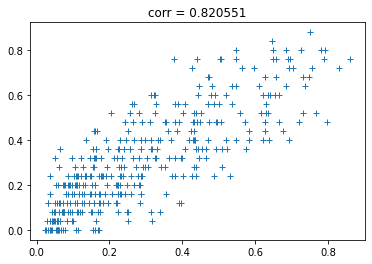

In [237]:
model = Sequential()

model.add(Conv3D(filters=32, kernel_size=5, activation='relu',padding='same', input_shape=(X_train_reshape.shape[1],X_train_reshape.shape[2],X_train_reshape.shape[3],1)))
model.add(MaxPooling3D())

model.add(Conv3D(filters=64, kernel_size=3, activation='relu',padding='same'))
model.add(MaxPooling3D())
model.add(Conv3D(filters=128, kernel_size=3, activation='relu',padding='same'))

model.add(Conv3D(filters=256, kernel_size=3, activation='relu',padding='same'))

#model.add(Conv3D(filters=512, kernel_size=3, activation='relu',padding='same'))

#model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
#model.add(Conv2D(filters=3, kernel_size=(1, 1), activation='relu'))
#model.add(AveragePooling2D())

model.add(Flatten())

#model.add(Dense(units=120, activation='relu'))

model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation = 'linear'))

model.compile(optimizer='adam', loss='mae')

history = model.fit(X_train_reshape, ytrain, validation_data=(X_test_reshape, ytest), epochs=13)
yy_test = model.predict(X_test_reshape)

test_corr = np.corrcoef(yy_test[:,0],y_test)[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,ytest,'+')

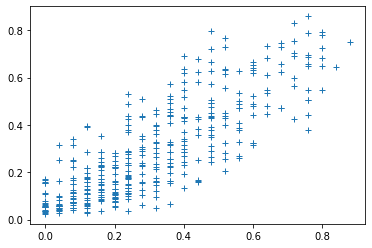

In [238]:
plt.plot(ytest,yy_test,'+')

# Fog Statistics

In [239]:
t2mAll=t2mTs.values
t2mAll=t2mAll[:,:,:,None]
t2mAll.shape

t850All=t850Ts.values
t850All=t850All[:,:,:,None]
t850All.shape

u850All=u850Ts.values
u850All=u850All[:,:,:,None]
u850All.shape


v850All=v850Ts.values
v850All=v850All[:,:,:,None]
v850All.shape


rhAll=rhTs.values
rhAll=rhAll[:,:,:,None]
rhAll.shape

u10All=u10Ts.values
u10All=u10All[:,:,:,None]
u10All.shape


zAll=zTs.values
zAll=zAll[:,:,:,None]
zAll.shape

v10All=v10Ts.values
v10All=v10All[:,:,:,None]
v10All.shape

X_All=np.array([zAll,rhAll,u10All,v10All,t2mAll])
X_All.shape

X_All_reshape = np.einsum('lkija->klija',X_All)
X_All_reshape.shape

(1922, 5, 18, 26, 1)

In [240]:
yLR=model.predict(X_All_reshape)

In [241]:
yLR[:,0]

array([0.2229932 , 0.27229527, 0.38349628, ..., 0.82079256, 0.7496825 ,
       0.65618086], dtype=float32)

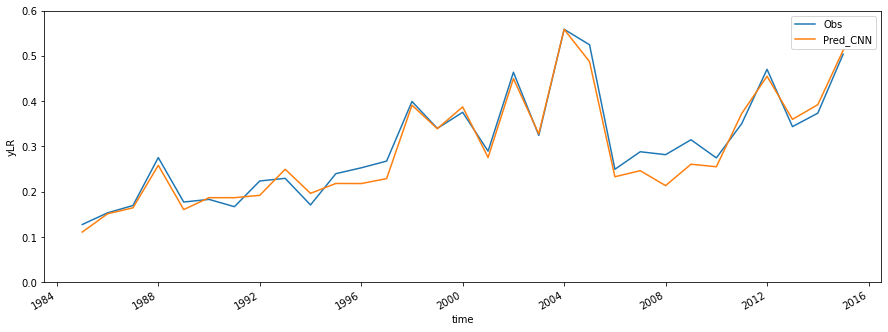

In [242]:
y_predLin_ds=xr.Dataset({'yLR': (('time'), yLR[:,0])}, coords={'time': y.time})
dump(y_predLin_ds.yLR,'TS1dataCNN.joblib')
plt.figure(figsize=[15,5])
y.resample(time='1Y').mean().plot(label='Obs')
y_predLin_ds.resample(time='1Y').mean().yLR.plot(label='Pred_CNN')
plt.ylim(0, 0.6)
plt.legend()

plt.savefig('../obs_yearly_CNN.jpeg',dpi=300)

In [243]:
ynf=y.where(y==0, drop=True)
ynf

yLRnf=y_predLin_ds.where(y_predLin_ds.yLR<0.04,drop=True)

yWd=y.where(y>0.44, drop=True)
yWd

yLRWd=y_predLin_ds.where(y_predLin_ds.yLR>0.44,drop=True)

yint1=y.where(y>0,drop=True)
yintf=yint1.where(yint1<0.48,drop=True)
yintf

yLRint1=y_predLin_ds.where(y_predLin_ds.yLR>0.039,drop=True)
yLRintf=yLRint1.where(yLRint1<0.48,drop=True)

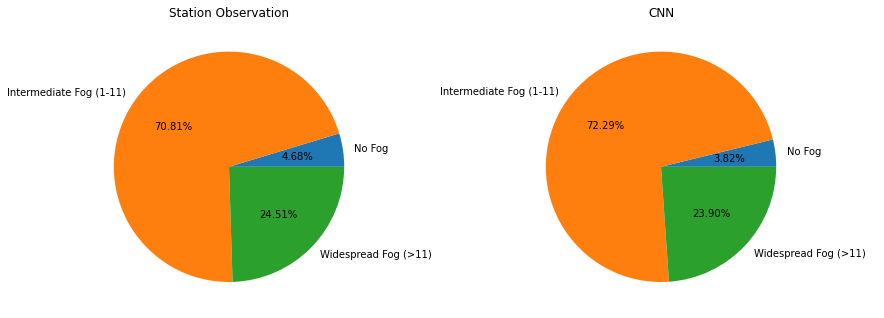

In [244]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [ynf.shape[0],yintf.shape[0],yWd.shape[0]]
ax.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax.set_title('Station Observation')

ax1 = fig.add_axes([1,0,1,1])
ax1.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [yLRnf.yLR.shape[0],yLRintf.yLR.shape[0],yLRWd.yLR.shape[0]]
ax1.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax1.set_title('CNN')
plt.show()

In [245]:
pie1dataCNN= [yLRnf.yLR.shape[0],yLRintf.yLR.shape[0],yLRWd.yLR.shape[0]]
dump(pie1dataCNN,'pie1dataCNN.joblib')

['pie1dataCNN.joblib']

In [246]:
noFogCounts=np.nan_to_num(ynf.resample(time='1Y').count(), copy=True, nan=0.0, posinf=None, neginf=None)
interFogCounts=yintf.resample(time='1Y').count()
wdFogCounts=yWd.resample(time='1Y').count()

In [247]:
#noFogCountsLR=np.nan_to_num(yLRnf.resample(time='1Y').count(), copy=True, nan=0.0, posinf=None, neginf=None)
noFogCountsLR=0
interFogCountsLR=yLRintf.resample(time='1Y').count()
wdFogCountsLR=np.nan_to_num(yLRWd.yLR.resample(time='1Y').count(), copy=True, nan=0.0, posinf=None, neginf=None)

Text(0.5, 1.0, 'CNN')

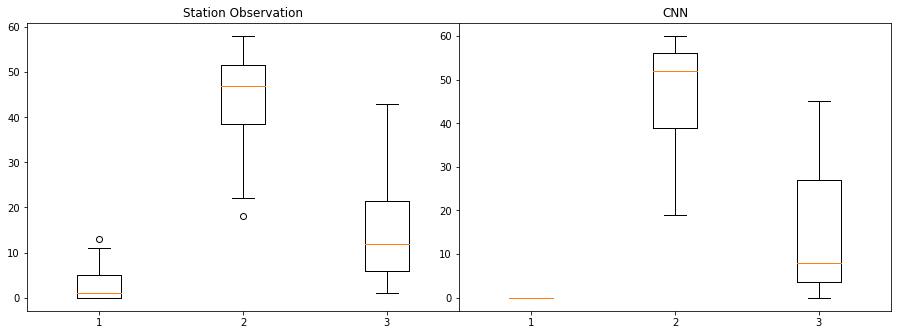

In [248]:
data = [noFogCounts, interFogCounts, wdFogCounts]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.boxplot(data)
ax.set_title('Station Observation')

dataLR = [noFogCountsLR, interFogCountsLR.yLR, wdFogCountsLR]
ax1 = fig.add_axes([1,0,1,1])
ax1.boxplot(dataLR)
ax1.set_title('CNN')

## test on 2015-2018 Data

In [249]:
zTst1=zTsAll.sel(time=slice('2015-1-1','2018-12-31'))
t2mTst1=t2mTsAll.sel(time=slice('2015-1-1','2018-12-31'))
t850Tst1=t850TsAll.sel(time=slice('2015-1-1','2018-12-31'))
u850Tst1=u850TsAll.sel(time=slice('2015-1-1','2018-12-31'))
v850Tst1=v850TsAll.sel(time=slice('2015-1-1','2018-12-31'))
rhTst1=rhTsAll.sel(time=slice('2015-1-1','2018-12-31'))
v10Tst1=v10TsAll.sel(time=slice('2015-1-1','2018-12-31'))
u10Tst1=u10TsAll.sel(time=slice('2015-1-1','2018-12-31'))
yt1=yAll.sel(time=slice('2015-1-1','2018-12-31'))

In [250]:
zTst2=zTsAll.sel(time=slice('1980-1-1','1983-12-31'))
t2mTst2=t2mTsAll.sel(time=slice('1980-1-1','1983-12-31'))
t850Tst2=t850TsAll.sel(time=slice('1980-1-1','1983-12-31'))
u850Tst2=u850TsAll.sel(time=slice('1980-1-1','1983-12-31'))
v850Tst2=v850TsAll.sel(time=slice('1980-1-1','1983-12-31'))
rhTst2=rhTsAll.sel(time=slice('1980-1-1','1983-12-31'))
v10Tst2=v10TsAll.sel(time=slice('1980-1-1','1983-12-31'))
u10Tst2=u10TsAll.sel(time=slice('1980-1-1','1983-12-31'))
yt2=yAll.sel(time=slice('1980-1-1','1983-12-31'))

In [251]:
zTst = xr.concat([zTst2, zTst1 ], dim='time')
t2mTst = xr.concat([t2mTst2, t2mTst1 ], dim='time')
t850Tst = xr.concat([t850Tst2, t850Tst1 ], dim='time')

u850Tst = xr.concat([u850Tst2, u850Tst1 ], dim='time')
v850Tst = xr.concat([v850Tst2, v850Tst1 ], dim='time')
rhTst = xr.concat([rhTst2, rhTst1 ], dim='time')
v10Tst = xr.concat([v10Tst2, v10Tst1 ], dim='time')
u10Tst = xr.concat([u10Tst2, u10Tst1 ], dim='time')
yt = xr.concat([yt2, yt1 ], dim='time')

In [252]:
t2m_t=t2mTst.values
t2m_t=t2m_t[:,:,:,None]
t2m_t.shape

t850_t=t850Tst.values
t850_t=t850_t[:,:,:,None]
t850_t.shape

u850_t=u850Tst.values
u850_t=u850_t[:,:,:,None]
u850_t.shape


v850_t=v850Tst.values
v850_t=v850_t[:,:,:,None]
v850_t.shape


rh_t=rhTst.values
rh_t=rh_t[:,:,:,None]
rh_t.shape

u10_t=u10Tst.values
u10_t=u10_t[:,:,:,None]
u10_t.shape


z_t=zTst.values
z_t=z_t[:,:,:,None]
z_t.shape

v10_t=v10Tst.values
v10_t=v10_t[:,:,:,None]
v10_t.shape

X_t=np.array([z_t,rh_t,u10_t,v10_t,t2m_t])
X_t.shape

X_t_reshape = np.einsum('lkija->klija',X_t)
X_t_reshape.shape

(496, 5, 18, 26, 1)

In [253]:
yLRt=model.predict(X_t_reshape)

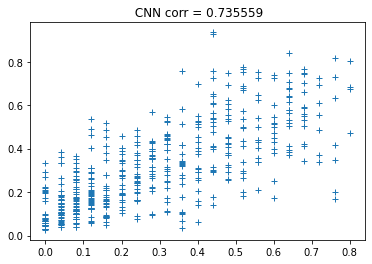

In [254]:
testcorr = np.corrcoef(yLRt[:,0],yt)[0,1]

#acc_svr       = round(regLin.score(Xt, yt) * 100, 2)

#print("Accuracy of base Linear Regression model is ,",(acc_svr/100)**0.5)

plt.title(' CNN corr = %f'%testcorr)

plt.plot(yt,yLRt[:,0],'+')



In [255]:
dump(yLRt[:,0],'TS2dataCNN.joblib')

['TS2dataCNN.joblib']

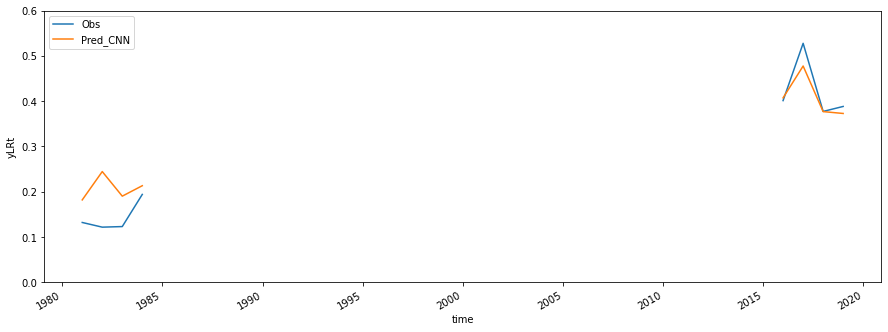

In [256]:
y_predLin_dst=xr.Dataset({'yLRt': (('time'), yLRt[:,0])}, coords={'time': yt.time})
dump(y_predLin_dst.yLRt,'TS2dataCNN.joblib')
plt.figure(figsize=[15,5])
yt.resample(time='1Y').mean().plot(label='Obs')
y_predLin_dst.resample(time='1Y').mean().yLRt.plot(label='Pred_CNN')
plt.ylim(0, 0.6)
plt.legend()

plt.savefig('../obs_yearly_CNN_2015-2018.jpeg',dpi=300)

In [257]:
ynft=yt.where(yt==0, drop=True)
ynft

yWdt=yt.where(yt>0.44, drop=True)
yWdt

yint1t=yt.where(yt>0,drop=True)
yintft=yint1t.where(yint1t<0.48,drop=True)
yintft

yLRnft=y_predLin_dst.where(y_predLin_dst.yLRt<0.04,drop=True)

yLRWdt=y_predLin_dst.where(y_predLin_dst.yLRt>0.44,drop=True)
yLRWdt

yLRint1t=y_predLin_dst.where(y_predLin_dst.yLRt>0.039,drop=True)
yLRintft=yLRint1t.where(yLRint1t<0.48,drop=True)
yLRintft

<xarray.Dataset>
Dimensions:  (time: 389)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2018-12-31
Data variables:
    yLRt     (time) float32 0.3136 0.294 0.2933 0.3415 ... 0.1644 0.1017 0.1003

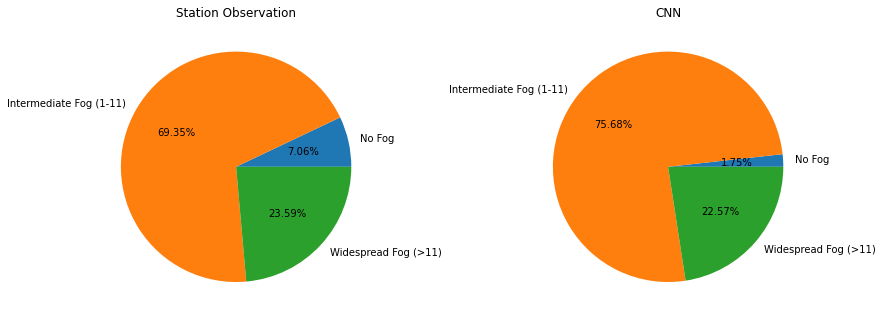

In [258]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [ynft.shape[0],yintft.shape[0],yWdt.shape[0]]
ax.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax.set_title('Station Observation')

ax1 = fig.add_axes([1,0,1,1])
ax1.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [yLRnft.yLRt.shape[0],yLRintft.yLRt.shape[0],yLRWdt.yLRt.shape[0]]
ax1.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax1.set_title('CNN')
plt.show()



In [259]:
yWdt.shape[0]

117

In [260]:
yLRWdt.yLRt.shape[0]

116

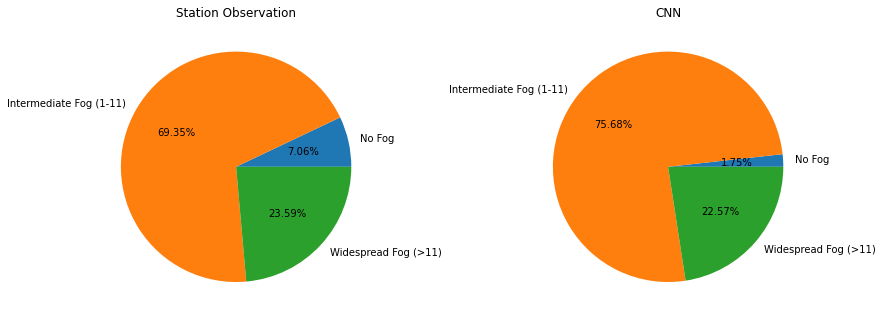

In [261]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [ynft.shape[0],yintft.shape[0],yWdt.shape[0]]
ax.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax.set_title('Station Observation')

ax1 = fig.add_axes([1,0,1,1])
ax1.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [yLRnft.yLRt.shape[0],yLRintft.yLRt.shape[0],yLRWdt.yLRt.shape[0]]
ax1.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax1.set_title('CNN')
plt.show()


In [262]:
pie1dataCNN= [yLRnft.yLRt.shape[0],yLRintft.yLRt.shape[0],yLRWdt.yLRt.shape[0]]
dump(pie1dataCNN,'pie2dataCNN.joblib')

['pie2dataCNN.joblib']